In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from zipfile import ZipFile
from urllib.request import urlretrieve
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.mkdir("/tmp/images")

if not os.path.isfile("horse_or_human.zip"):
  url = "https://storage.googleapis.com/learning-datasets/horse-or-human.zip"
  urlretrieve(url, filename="horse_or_human.zip")

with ZipFile("horse_or_human.zip", "r") as Zip:
  Zip.extractall("/tmp/images")

In [ ]:
generator = ImageDataGenerator(rescale=1.0/255)

training_data = generator.flow_from_directory("/tmp/images",
                                              target_size=(300, 300),
                                              batch_size=128,
                                              class_mode="binary")

Found 1027 images belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(layers.Conv2D(16, kernel_size=3, activation="relu", input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, kernel_size=3, activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(training_data, epochs=10, verbose=1)

Epoch 1/10
9/9 [==============================] - 15s 804ms/step - loss: 0.7151 - accuracy: 0.5589
Epoch 2/10
9/9 [==============================] - 8s 828ms/step - loss: 0.6394 - accuracy: 0.6543
Epoch 3/10
9/9 [==============================] - 8s 784ms/step - loss: 0.6151 - accuracy: 0.7030
Epoch 4/10
9/9 [==============================] - 8s 891ms/step - loss: 0.4544 - accuracy: 0.7975
Epoch 5/10
9/9 [==============================] - 8s 849ms/step - loss: 0.2036 - accuracy: 0.9464
Epoch 6/10
9/9 [==============================] - 8s 820ms/step - loss: 0.4517 - accuracy: 0.8802
Epoch 7/10
9/9 [==============================] - 8s 869ms/step - loss: 0.1461 - accuracy: 0.9426
Epoch 8/10
9/9 [==============================] - 7s 801ms/step - loss: 0.5520 - accuracy: 0.8335
Epoch 9/10
9/9 [==============================] - 8s 872ms/step - loss: 0.0877 - accuracy: 0.9834
Epoch 10/10
9/9 [==============================] - 8s 868ms/step - loss: 0.2350 - accuracy: 0.9328


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x /= 255

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)

1/1 [==============================] - 0s 87ms/step


<ipython-input-10-5c04ffa64243>:31: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


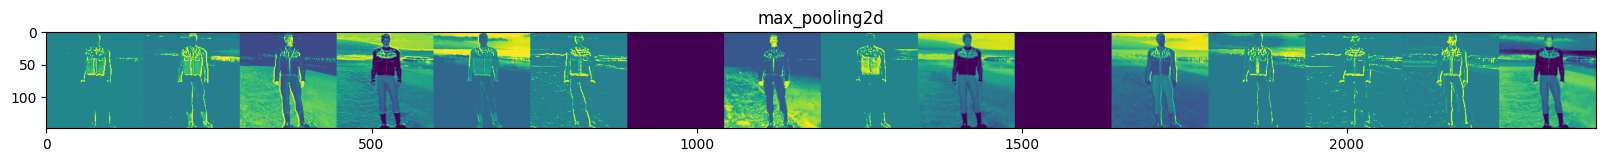

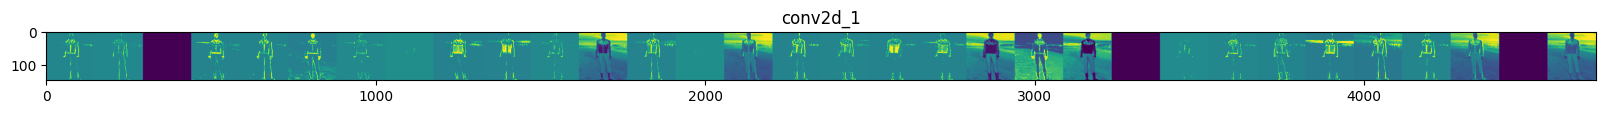

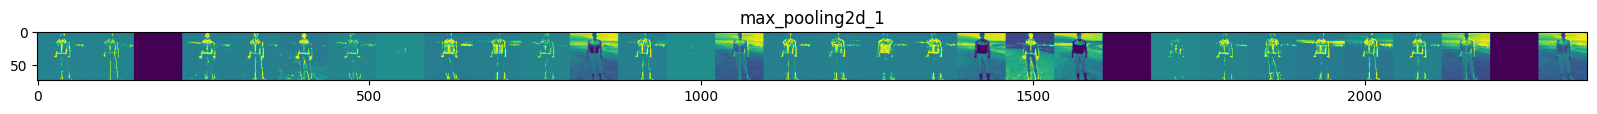

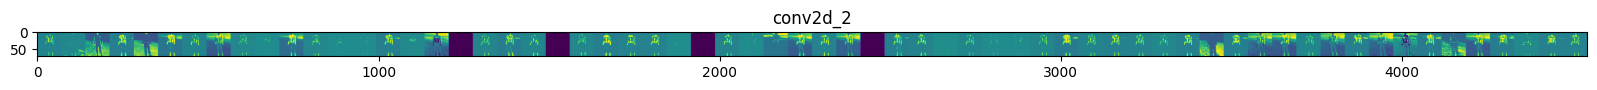

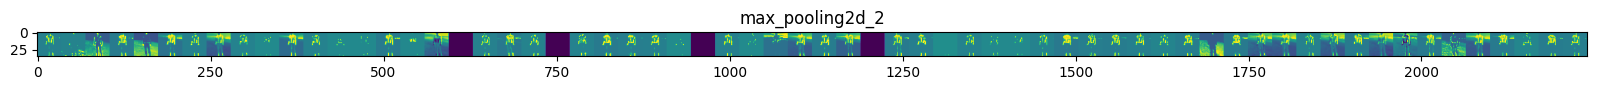

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model.input, outputs = successive_outputs)

x = np.expand_dims(training_data[0][0][7], axis=0)

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
!rm -rf /tmp/images